# MBTI Classifier - Running models on bigrams

### -- Prepocessing --

#### Import libraries and raw data

In [1]:
# import all libraries needed
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import svm

In [2]:
# read in raw data file, print shape & preview header
mbti = pd.read_csv('mbti_1.csv')
print(mbti.shape)
mbti.head()

(8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


#### Get metadata on raw text

In [3]:
# import file with helper functions to obtain metadata (excluding emojis due to unknown error)
from helpers import count_caps, count_exclamations, count_digits, count_emojis_shortcode, show_cf, show_roc_graph

In [4]:
# run functions ()
mbti['count_of_caps'] = mbti.posts.apply(lambda x: count_caps(x))
mbti['count_of_exclamations'] = mbti.posts.apply(lambda x: count_exclamations(x))
mbti['count_of_digits'] = mbti.posts.apply(lambda x: count_digits(x))

In [5]:
# preview new dataframe
mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,153,3,109
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109
2,INTP,'Good one _____ https://www.youtube.com/wat...,169,4,94
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33
4,ENTJ,'You're fired.|||That's another silly misconce...,261,1,41


#### Now that we have our metadata, next steps are: 
1) Clean text (remove hyperlinks, special characters & digits)<br>
2) Tokenize<br>

In [6]:
# 1) clean text - remove hyperlinks, special characters & digits
mbti.posts = mbti.posts.apply(lambda x: re.sub(r"(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?", "", x))
mbti.posts = mbti.posts.apply(lambda x: re.sub(r"\|", "", x))
mbti.posts = mbti.posts.apply(lambda x: re.sub(r"\d", "", x))
mbti.posts = mbti.posts.apply(lambda x: re.sub(r"_", "", x))

In [7]:
mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109
2,INTP,"'Good one Of course, to which I say I know...",169,4,94
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41


In [8]:
# 2) Tokenize only (don't remove stopwords since we plan to use bigrams)

def lower(text):
    """Return lower-case text of each work in a list"""
    return [word.lower() for word in text]

# tokenize & lower-case all words
tokenizer = RegexpTokenizer(r'\w+')
mbti['raw_tokens'] = mbti.posts.apply(lambda x: tokenizer.tokenize(x))
mbti['raw_tokens'] = mbti.raw_tokens.apply(lambda x: lower(x))
mbti['raw_tokens'] = mbti.raw_tokens.apply(lambda x: " ".join(x))

In [9]:
mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,raw_tokens
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,enfp and intj moments sportscenter not top ten...
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,i m finding the lack of me in these posts very...
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,good one of course to which i say i know that ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,dear intp i enjoyed our conversation the other...
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,you re fired that s another silly misconceptio...


### -- Modeling --

#### We'll run the following models:
1) Multinomial Naive Bayes <br>
2) Random Forest<br>
3) Linear SVC<br>
4) Xgboost

But first, we'll perform train, test, split and transform our features to bigram using  a count vectorizer.

In [10]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
# create variables for features and labels
X = mbti.raw_tokens
y = mbti.type

In [12]:
# fit the features first, then split
vectorizer = CountVectorizer(ngram_range=(2,2))
X_bigrams = vectorizer.fit_transform(X)

In [13]:
# perform train, test, split (on random_state 10 for comparison against other model performances)
X_train, X_test, y_train, y_test = train_test_split(X_bigrams, y, test_size = 0.2, random_state=5, stratify = y)

1) Multinomial Naive Bayes

In [14]:
# create & fit multinomialNB classifier on train set
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

nb_test_preds = nb_classifier.predict(X_test)
nb_test_score = classification_report(y_test, nb_test_preds)
print("Baseline MultinomialNB Classifer (test): \n", nb_test_score)

Baseline MultinomialNB Classifer (test): 
               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.00      0.00      0.00       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.00      0.00      0.00       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.32      0.11      0.16       294
        INFP       0.22      0.98      0.36       367
        INTJ       0.20      0.00      0.01       218
        INTP       0.69      0.03      0.07       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

   micro avg       0.23      0.23    

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
confusion_matrix(y_test, nb_test_preds)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   4,  34,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   4, 131,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,  43,   1,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  11, 126,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   8,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   8,   0,   1,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   7,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,  17,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  31, 260,   1,   2,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   8, 358,   0,   1,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   

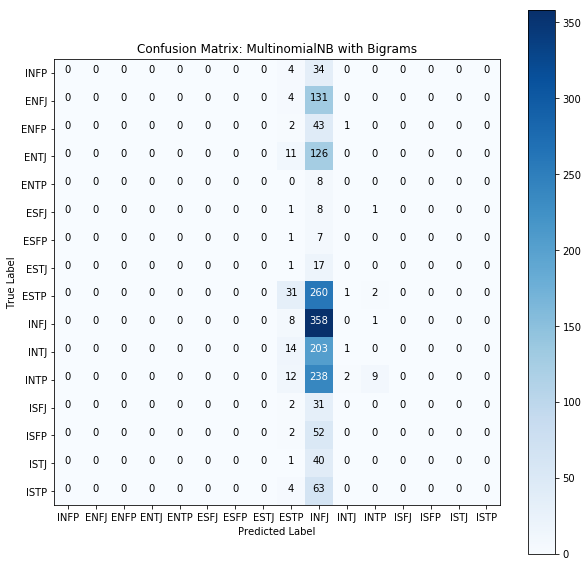

In [16]:
show_cf(y_test, nb_test_preds, model_name='MultinomialNB with Bigrams')

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

def show_roc_graph(model, X_train, X_test, y_train, y):
    
    classes = ['INFP', 'ENFJ', 'ENFP', 'ENTJ', 'ENTP',
                                       'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ',
                                       'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ',
                                       'ISTP']
    
    y_bin = label_binarize(y, classes=classes)
    
    X_train, X_test, y_train, y_test = train_test_split(X_bigrams, y_bin, test_size = 0.2, random_state=5, stratify = y)
    
    
    n_classes = len(classes)
    classifier = OneVsRestClassifier(nb_classifier)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black', 'pink', 'grey', 'teal',
                       'cyan', 'magenta', 'salmon', 'peru', 'lime'])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for MultinomialNB w/ bigrams (baseline)')
    plt.legend(loc="lower right")
    plt.show()


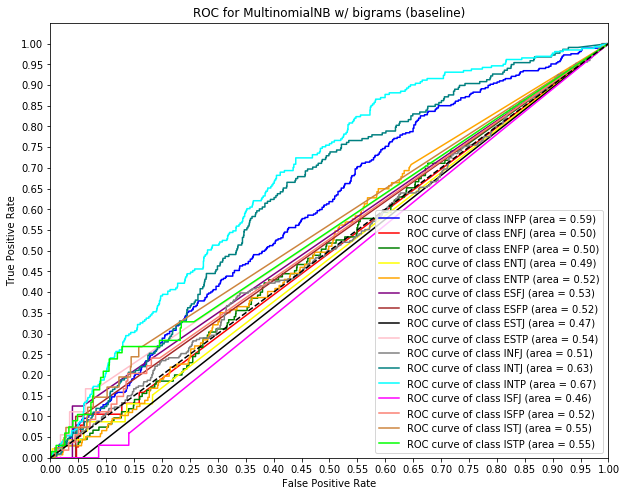

In [18]:
show_roc_graph(nb_classifier, X_train, X_test, y_train, y)

2) Random Forest

In [19]:
X = mbti.raw_tokens
y = mbti.type

def get_tts_values(X, y):
    vectorizer = CountVectorizer(ngram_range=(2,2))
    X_bigrams = vectorizer.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_bigrams, y, test_size = 0.2, random_state=5, stratify = y)
    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = get_tts_values(X, y)

In [21]:
# create & fit RandomForest classifier on train set
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

rf_test_preds = rf_classifier.predict(X_test)
rf_test_score = classification_report(y_test, rf_test_preds)
print("Random Forest Classifer w/ Bigrams (test): \n", rf_test_score)

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Classifer w/ Bigrams (test): 
               precision    recall  f1-score   support

        ENFJ       0.33      0.03      0.05        38
        ENFP       0.26      0.15      0.19       135
        ENTJ       0.12      0.02      0.04        46
        ENTP       0.39      0.30      0.34       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.33      0.06      0.10        18
        INFJ       0.34      0.53      0.42       294
        INFP       0.32      0.66      0.43       367
        INTJ       0.42      0.24      0.30       218
        INTP       0.34      0.25      0.29       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       1.00      0.04      0.07        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.58      0.10      0.18        67

   micro avg       0.34      0.34  

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


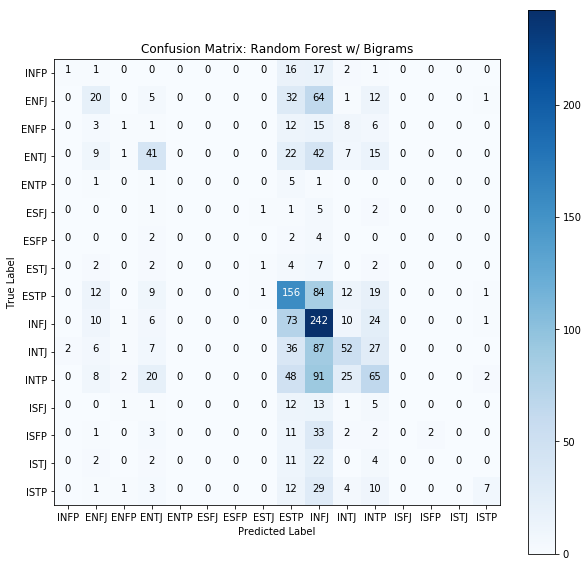

In [22]:
show_cf(y_test, rf_test_preds, model_name='Random Forest w/ Bigrams')

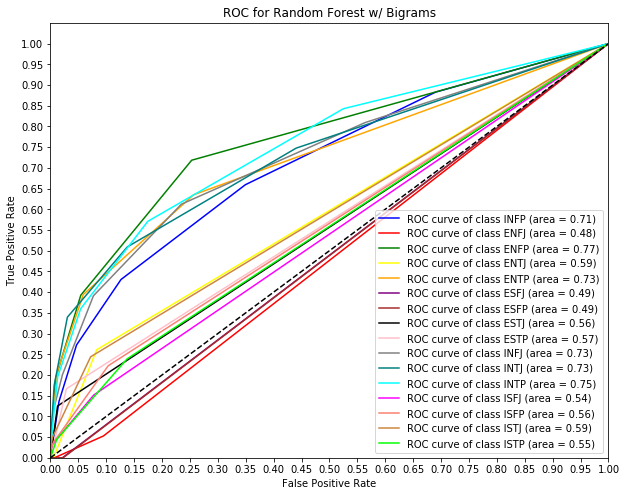

In [23]:
# ROC graph
    
classes = ['INFP', 'ENFJ', 'ENFP', 'ENTJ', 'ENTP',
            'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ',
            'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ',
            'ISTP']

y_bin = label_binarize(y, classes=classes)

X_train, X_test, y_train, y_test = train_test_split(X_bigrams, y_bin, test_size = 0.2, random_state=5, stratify = y)


n_classes = len(classes)
classifier = OneVsRestClassifier(rf_classifier)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black', 'pink', 'grey', 'teal',
                   'cyan', 'magenta', 'salmon', 'peru', 'lime'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest w/ Bigrams')
plt.legend(loc="lower right")
plt.show()


3) Linear SVC

In [37]:
X = mbti.raw_tokens
y = mbti.type

X_train, X_test, y_train, y_test = get_tts_values(X, y)

In [ ]:
# create & fit linear SVC classifier on train set
svc = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
svc.fit(X_train, y_train)

svc_test_preds = svc.predict(X_test)
svc_test_score = classification_report(y_test, svc_test_preds)
print("Linear SVC (test): \n", svc_test_score)

In [ ]:
show_cf(y_test, rf_test_preds, model_name='Linear SVC w/ Bigrams')

In [ ]:
# ROC graph
    
classes = ['INFP', 'ENFJ', 'ENFP', 'ENTJ', 'ENTP',
            'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ',
            'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ',
            'ISTP']

y_bin = label_binarize(y, classes=classes)

X_train, X_test, y_train, y_test = train_test_split(X_bigrams, y_bin, test_size = 0.2, random_state=5, stratify = y)


n_classes = len(classes)
classifier = OneVsRestClassifier(svc)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black', 'pink', 'grey', 'teal',
                   'cyan', 'magenta', 'salmon', 'peru', 'lime'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Linear SVC w/ bigrams')
plt.legend(loc="lower right")
plt.show()

In [33]:
text_string = "the Border, or large sections of the Border, next week. This would be so easy for Mexico to do, but they just take our money and “talk.” Besides, we lose so much money with them, especially when you add in drug trafficking etc.), that the Border closing would be a good thing!"

In [34]:
def predict_MBTI(text_string):
    vectorizer = CountVectorizer(ngram_range=(2,2))
    text_bigrams = vectorizer.fit_transform(text_string)
    prediction = rf_classifier.predict(text_bigrams)
    return prediction

In [35]:
predict_MBTI(text_string)

ValueError: Iterable over raw text documents expected, string object received.